In [1]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [2]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

In [ ]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    'rating',
    'startYear',
    'canHaveEpisodes',
    'runtimeMinutes_notitletype',
    'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western',
    'is_Music', 
    # 'is_Film-Noir',
    'is_Adult',
    'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
    'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    'is_Sport', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    'countryOfOrigin_OC',
    'countryOfOrigin_SA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_UNK',
    'criticReviewsTotal', 'userReviewsTotal',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
]

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform


# Prepare the data
X_train = train[feats]
y_train = train['titleType']

X_test = test[feats]
y_test = test['titleType']

# Scale the features


# Define the model
dt = DecisionTreeClassifier(random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1,50),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': [None, 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=500,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the model on the training set
y_train_pred = random_search.best_estimator_.predict(X_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 34, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 18, 'splitter': 'best'}
Best Score: 0.8244832362916107
Train Set Classification Report:
              precision    recall  f1-score   support

       movie       0.90      0.94      0.92      5535
       short       0.93      0.96      0.95      2474
   tvEpisode       0.92      0.95      0.93      4698
tvMiniSeries       0.70      0.56      0.63       224
     tvMovie       0.67      0.49      0.57       868
    tvSeries       0.93      0.96      0.95      1375
     tvShort       0.55      0.15      0.24        40
   tvSpecial       0.51      0.26      0.34       166
       video       0.77      0.61      0.68       792

    accuracy                           0.89     16172
   macro avg       0.76      0.65      0.69     16172
weighted avg       0.89      0.89      0.89     16172

Test Set Classification Report:
              precision    recall  f1-score   supp

In [5]:
random_search.best_estimator_.feature_importances_

array([8.46402088e-02, 2.36276573e-02, 4.06889143e-02, 1.58569360e-02,
       1.85699569e-02, 6.53189783e-02, 2.17468832e-01, 1.61529068e-01,
       9.43592434e-03, 7.73234193e-05, 1.22552551e-03, 3.71595090e-04,
       6.00843695e-04, 4.49389095e-03, 1.44458714e-04, 3.34814928e-04,
       1.28454446e-03, 3.93855657e-03, 2.15540123e-02, 8.26254069e-04,
       2.31404528e-04, 5.36655823e-04, 2.69229237e-03, 2.35578231e-01,
       4.91506347e-04, 2.36411682e-03, 5.80457151e-04, 8.20258783e-04,
       6.13694062e-03, 3.42269699e-04, 9.08747830e-04, 7.41498651e-03,
       3.57039249e-02, 1.34871368e-03, 1.10494068e-02, 2.04004615e-03,
       9.76800844e-04, 1.82936994e-04, 2.36785902e-03, 8.08890217e-03,
       8.15524608e-03])

In [6]:
train.loc[train['countryOfOrigin_AF'] >= 1]

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,countryOfOrigin_AF,countryOfOrigin_AS,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno,totalNominations,totalMedia,runtimeMinutes_notitletype
124,El Banat Ayza Eih,6,1980,1980.0,NaN,0.0,95,3,0,19,...,1,0,0,0,0,0,86.0,0.0,3,62.0
142,Hokm al kawi,8,1951,1951.0,103.0,0.0,21,2,0,10,...,1,0,0,0,0,0,103.0,0.0,2,103.0
295,Al Shaweesh Hassan,4,1988,1988.0,100.0,0.0,11,1,0,11,...,1,0,0,0,0,0,100.0,0.0,1,100.0
618,Captain Gallant of the Foreign Legion,8,1955,NaN,30.0,0.0,118,14,0,119,...,1,0,1,0,0,0,30.0,0.0,14,30.0
678,Hayat azeb,6,1963,1963.0,87.0,0.0,26,1,0,18,...,1,0,0,0,0,0,87.0,0.0,1,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15991,The Exchange: Six Faces of the Gambia,6,2009,2009.0,23.0,0.0,8,0,0,6,...,1,0,0,0,0,0,23.0,0.0,0,23.0
16032,Ace of Hearts: Bwana Y'umutima,9,2017,2017.0,120.0,0.0,13,2,0,18,...,1,0,0,0,0,0,120.0,0.0,2,120.0
16055,Soultan,7,1958,1958.0,115.0,0.0,53,1,0,16,...,1,0,0,0,0,0,115.0,0.0,1,115.0
16067,Afrobeats: From Nigeria to the World,7,2017,2017.0,52.0,0.0,14,1,0,9,...,4,0,1,0,0,0,52.0,0.0,1,52.0


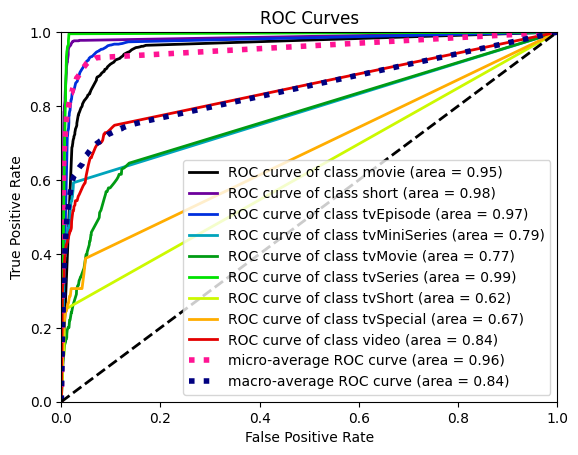

In [25]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

plot_roc(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

In [30]:
y_test

0              video
1              movie
2          tvSpecial
3          tvEpisode
4          tvEpisode
            ...     
5379           video
5380       tvEpisode
5381           movie
5382        tvSeries
5383    tvMiniSeries
Name: titleType, Length: 5384, dtype: object

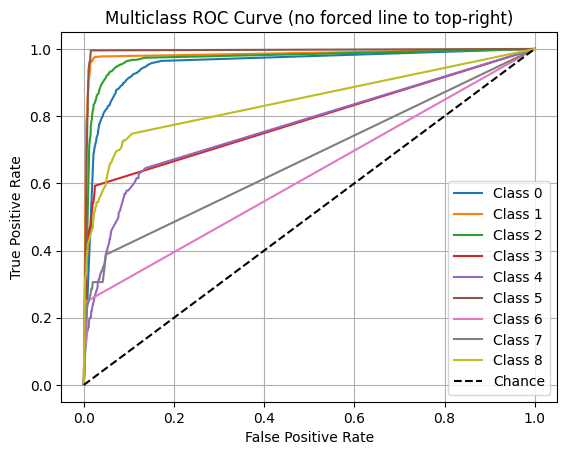

In [32]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities once, not inside the loop
proba = random_search.best_estimator_.predict_proba(X_test)

# Determine number of classes
n_classes = proba.shape[1]

# Binarize the true labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

y_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (no forced line to top-right)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


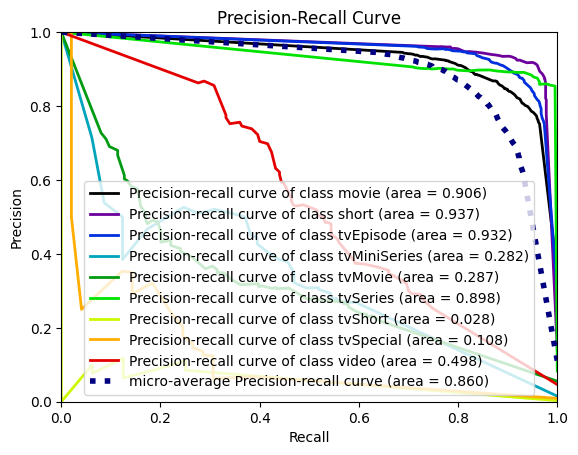

In [26]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

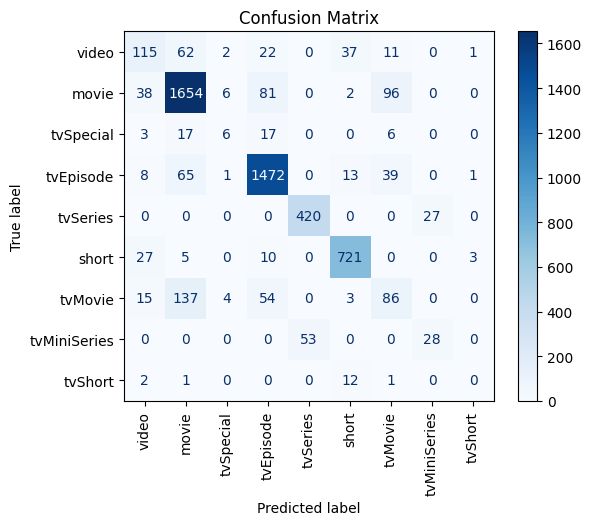

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

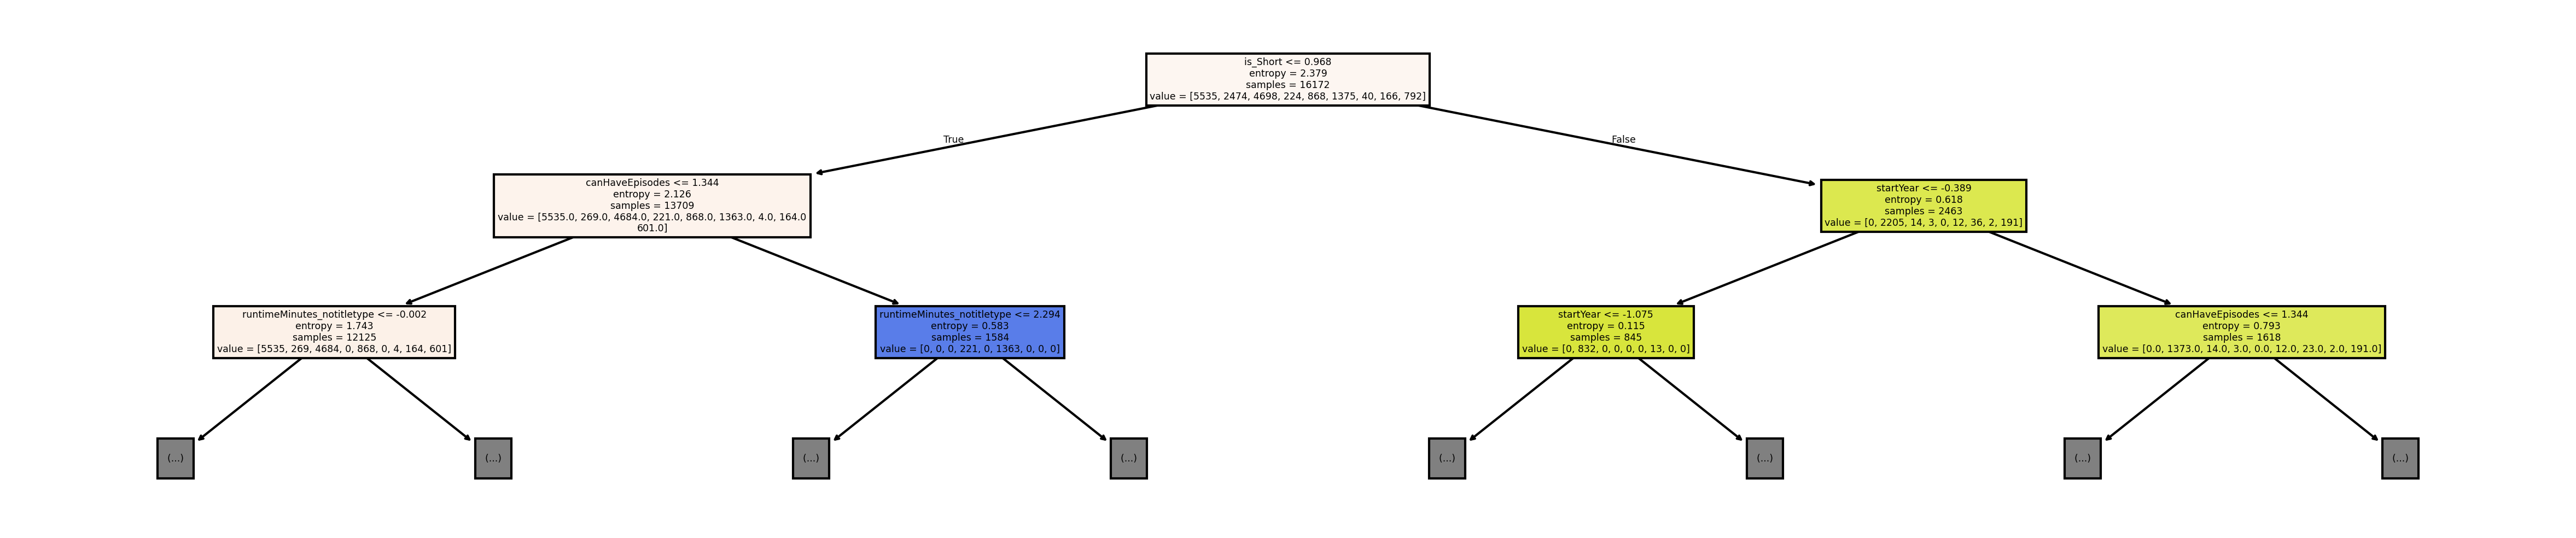

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 4), dpi=300)
plot_tree(random_search.best_estimator_, feature_names=feats, filled=True, max_depth=2)
plt.show()